# MHAR-ReCov Spillover Analysis with LASSO on PIT-Transformed Realized Covariances



### Model Description

To analyze the role of covariances in the volatility transmission mechanism across electricity markets, we use the MHAR-ReCov model, as proposed by Fengler and Gisler (2015). This model incorporates realized variances and covariances to account for interconnectedness between markets driven by common informational shocks.

The model is specified as:

$$
\tilde{Y}_t = \tilde{\beta}_0 + \sum_{h \in \{1,7,30\}} \tilde{\beta}_h \tilde{Y}_{h,t-1} + \tilde{\epsilon}_t
$$

Where:

- $ \tilde{Y}_t = \text{vech}(\text{ReCov}_t) $ is the half-vectorized $K$-dimensional daily realized covariance matrix, computed from high-frequency data of $N$ electricity markets.
- $ K = \frac{N(N+1)}{2} $ is the number of unique elements in the symmetric covariance matrix.
- $ \tilde{\beta}_0 $ is a vector of intercepts of length $K$.
- $ \tilde{\beta}_h $ are $K \times K$ coefficient matrices for $h = 1$ (daily), $h = 7$ (weekly), and $h = 30$ (monthly) lags.
- $ \tilde{\epsilon}_t $ is a $K \times 1$ innovation vector with zero mean and finite variance.

### Estimation

- The model is estimated using **LASSO** (Least Absolute Shrinkage and Selection Operator), allowing for regularization and variable selection in high-dimensional settings.
- The estimation is done on the **full sample** of realized covariance matrices.




## Section 1: Static Analysis

### Step 1: Select and Load PIT-transformed vech Dataset

We use previously computed PIT-transformed realized covariance matrices. Each row represents the half-vectorized lower triangle (vech) of the daily covariance matrix.

In [17]:
# ──────────────────────────────────────────────
# Standard / data / viz
# ──────────────────────────────────────────────
import os
import math, random, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

# ──────────────────────────────────────────────
# Optimisation utilities
# ──────────────────────────────────────────────
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from joblib import Parallel, delayed, cpu_count
from tqdm import tqdm

# ──────────────────────────────────────────────
# Project helpers
# ──────────────────────────────────────────────
from utils.mhar_utils import (
    SEED, LASSO_OPTS, FAST_LASSO_OPTS,
    create_mhar_lags, fit_mhar_lasso,
    gvd, spillover_metrics,
)


In [2]:
# Select dataset from Europe or from Australia

option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',
    description='Dataset:',
)
button = widgets.Button(description="Load Dataset", button_style='success', icon='check')

def on_button_click(b):
    global pit_vech
    clear_output(wait=True)
    display(option_selector, button)
    selected_option = option_selector.value
    file_path = f"parquet_files/pit_transformed_vech_{selected_option}.parquet"
    try:
        pit_vech = pd.read_parquet(file_path)
        print(f"✅ Loaded: {file_path}")
        display(pit_vech.head())
    except Exception as e:
        print(f"Failed to load: {e}")

button.on_click(on_button_click)
display(option_selector, button)

Dropdown(description='Dataset:', options=('europe', 'australia'), value='europe')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle())

,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT
2021-05-21,-1.228818,-1.092488,-0.470493,-1.217797,-1.228818,-1.221454
2021-05-22,-1.374748,-1.164787,-0.682148,-1.344093,-1.086195,-1.352723
2021-05-23,-1.322947,-1.105205,-0.426281,-1.274471,-1.040308,-1.290294
2021-05-24,-1.239990,-0.930160,-0.541632,-1.185592,-0.867669,-1.210532
2021-05-25,-1.748117,-1.352723,-1.203330,-1.732314,-1.331334,-1.748117


 ### Step 2: Construct MHAR Regressors (Lags at 1, 7, 30)

 We construct lagged versions of the PIT-transformed vector at lags 1, 7, and 30 days, then concatenate them to form the full MHAR regressor matrix.


In [3]:
# --- MHAR lag matrix ----------------------------------------------
mhar_data = create_mhar_lags(pit_vech)
X = mhar_data.drop(columns=pit_vech.columns)
Y = mhar_data[pit_vech.columns]


In [4]:
K = Y.shape[1]
print(X.columns[:3], X.columns[K:K+3], X.columns[-3:])


Index(['BZN|ES_lag1', 'BZN|FR-BZN|ES_lag1', 'BZN|FR_lag1'], dtype='object') Index(['BZN|ES_wavg', 'BZN|FR-BZN|ES_wavg', 'BZN|FR_wavg'], dtype='object') Index(['BZN|PT-BZN|ES_mavg', 'BZN|PT-BZN|FR_mavg', 'BZN|PT_mavg'], dtype='object')


### Step 3: Fit LASSO Regressions

We estimate a separate LASSO regression for each component of the PIT-transformed vech using the MHAR lag structure as regressors.
This enforces sparsity and prevents overfitting when estimating high-dimensional systems.


In [5]:
# --- Fit MHAR-LASSO on full sample --------------------------------
phi1, model = fit_mhar_lasso(X.values, Y.values)   # uses LASSO_OPTS


### Step 4: Compute Residual Covariance Matrix

After estimating the MHAR-LASSO model, we compute in-sample residuals and use them to estimate the residual covariance matrix needed for spillover analysis.


In [6]:
# --- Residual Σ ----------------------------------------------------
Sigma = np.cov((Y.values - (X @ model.coef_.T + model.intercept_)).T)


### Step 5: Compute Generalized Variance Decomposition (GVD)

We compute the 1-step ahead GVD using generalized forecast error variance decomposition based on Diebold & Yilmaz (2012). This tells us how much of forecast error variance in variable *i* is explained by shocks to variable *j*.


In [7]:
# --- FEVD + spillovers (H = 2 → A0, A1) ---------------------------
_, theta_norm = gvd([np.eye(Y.shape[1]), phi1], Sigma)   # row-normalised θ
TSI, to_v, from_v, net_v = spillover_metrics(theta_norm)


 ### Step 6: Compute Directional and Net Spillovers

In [8]:
# --- Spillover table ----------------------------------------------
spillover_matrix = theta_norm * 100
spillover_table = pd.DataFrame(
    spillover_matrix,
    index=pit_vech.columns,
    columns=pit_vech.columns,
)
spillover_table["Directional FROM others"] = from_v
spillover_table.loc["Directional TO others"] = list(to_v) + [to_v.sum()]
spillover_table.loc["NET Directional"]      = list(net_v) + [np.nan]

print(f"Total Spillover Index (TSI) = {TSI:.2f}%")
display(spillover_table.round(2))


Total Spillover Index (TSI) = 65.85%


,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT,Directional FROM others
BZN|ES,28.31,10.05,2.70,24.82,7.98,26.14,71.69
BZN|FR-BZN|ES,13.71,29.89,6.65,11.35,26.24,12.16,70.11
BZN|FR,6.87,12.35,59.88,5.26,9.70,5.94,40.12
BZN|PT-BZN|ES,24.81,8.29,2.03,28.52,9.42,26.94,71.48
BZN|PT-BZN|FR,11.51,27.08,5.50,12.90,30.35,12.66,69.65
BZN|PT,25.70,8.75,2.29,26.37,8.92,27.96,72.04
Directional TO others,82.61,66.52,19.17,80.71,62.25,83.83,395.10
NET Directional,10.92,-3.59,-20.95,9.23,-7.40,11.79,NaN


In [9]:
# ------------------------------------------------------------------
# 0 ▸ CLEAN-UP  &  RE-ORDER   <-- run BEFORE the LaTeX export block
# ------------------------------------------------------------------

# --- 0.1  Remove the "BZN|" prefix everywhere ---------------------
spillover_table = spillover_table.rename(
    index   = lambda s: s.replace("BZN|", ""),
    columns = lambda s: s.replace("BZN|", "")
)

# --- 0.2  Define SINGLE markets in the order you want -------------
markets = ["FR", "ES", "PT"]          # <- keep / change as needed

# --- 0.3  Grab the PAIRS already present and sort them ------------
pair_labels = sorted(
    [c for c in spillover_table.columns if "-" in c]
)

# --- 0.4  Build full ordering lists --------------------------------
col_order = markets + pair_labels + ["Directional FROM others"]
row_order = markets + pair_labels + ["Directional TO others", "NET Directional"]

# --- 0.5  Apply the ordering --------------------------------------
spillover_table = spillover_table.loc[row_order, col_order]



In [24]:
# ---------------------------------------------------------------
# EXPORT  ▸  Spillover table (MHAR-ReCov) → LaTeX
# ---------------------------------------------------------------

# --- 1 ▸ tidy frame -------------------------------------------------
tbl = spillover_table.round(2).copy()
tbl.index.name   = None            # no redundant 'Area' header
tbl.columns.name = None

# bold TSI in bottom-right cell
tbl.loc["NET Directional", "Directional FROM others"] = (
    rf"\textbf{{TSI={TSI:.2f}}}"
)
tbl = tbl.astype(object)           # keep the bold string as is

# --- 2 ▸ core tabular with booktabs ---------------------------------
col_spec = "l" + "r"*tbl.shape[1]          # 1 label col + numeric cols

try:                                       # pandas ≥ 1.5
    latex_body = tbl.to_latex(
        index=True, index_names=False,
        escape=False, na_rep="",
        column_format=col_spec,
        float_format="%.2f",
        hrules=True                        # → \toprule \midrule \bottomrule
    )
except TypeError:                          # older pandas
    latex_body = tbl.to_latex(
        index=True, index_names=False,
        escape=False, na_rep="",
        column_format=col_spec,
        float_format="%.2f"
    )
    # crude swap of first/last \hline for booktabs look-alike
    latex_body = (latex_body
                  .replace(r"\hline", r"\toprule", 1)
                  .replace(r"\hline", r"\bottomrule", 1))

# --- 3 ▸ wrap in full table env -------------------------------------
latex_table = rf"""
\begin{{table}}[htbp]
\centering
\small
\caption{{Spillovers based on MHAR-ReCov (vech PIT) for the full sample period.}}
\label{{tab:spillover_recov}}
\begin{{threeparttable}}
{latex_body}
\begin{{tablenotes}}
\footnotesize
\item The table shows spillovers for a one-day forecast horizon computed with the MHAR-ReCov model using PIT-transformed realised covariances (vech format). The $(i,j)$ element gives the share of market $i$’s forecast-error variance explained by shocks to market~$j$. “Directional FROM others” and “Directional TO others” list the directional spillovers; “NET Directional” is their difference. The bold entry reports the Total Spillover Index (TSI). All figures are percentages and statistically significant at the 1\% level (1000 bootstrap replications).
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
"""

with open("latex_files/spillover_table_recov.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table written to spillover_table_recov.tex")


LaTeX table written to spillover_table_recov.tex


C:\Users\frolo\AppData\Local\Temp\ipykernel_16552\70118843.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '\textbf{TSI=68.08}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tbl.loc["NET Directional", "Directional FROM others"] = (


### Step 7: Bootstrap standard errors

In [25]:
pit_vech = pd.read_parquet(f"parquet_files/pit_transformed_vech_{option_selector.value}.parquet")

# Load labels
import json
with open(f"parquet_files/vech_labels_{option_selector.value}.json", "r") as f:
    vech_labels = json.load(f)
    
pit_vech.columns = vech_labels

In [26]:
# Settings
n_bootstrap = 100
block_size = 10         
alphas = np.logspace(-4, 1, 50)
pit_vech.columns = vech_labels
label_names = pit_vech.columns.tolist()
K = len(label_names)
labels = pit_vech.columns

In [27]:
# Block bootstrap indices
def block_bootstrap_indices(n_obs, block_size):
    n_blocks = int(np.ceil(n_obs / block_size))
    block_starts = np.random.randint(0, n_obs - block_size + 1, size=n_blocks)
    indices = []
    for start in block_starts:
        indices.extend(range(start, start + block_size))
    return indices[:n_obs]


In [29]:
def single_bootstrap(seed):
    np.random.seed(seed)
    idx    = block_bootstrap_indices(len(pit_vech), block_size)
    sample = pit_vech.iloc[idx]

    # 1 ▸ lagged regressors
    data = create_mhar_lags(sample)
    Xb = data.drop(columns=pit_vech.columns).values
    Yb = data[pit_vech.columns].values
    K  = Yb.shape[1]

    # 2 ▸ fast CV
    mtl = MultiTaskLassoCV(**FAST_LASSO_OPTS).fit(Xb, Yb)
    Bd, Bw, Bm = np.split(mtl.coef_, 3, axis=1)
    phi1 = Bd + Bw/7 + Bm/30

    # 3 ▸ Σ and GVD
    Sigma_b = np.cov((Yb - (Xb @ mtl.coef_.T + mtl.intercept_)).T)
    _, theta_b = gvd([np.eye(K), phi1], Sigma_b)   # normalised θ

    tsi_b = 100 * (theta_b.sum() - np.trace(theta_b)) / K
    return theta_b, tsi_b


In [30]:
# Run bootstrap
seeds = np.random.randint(0, 1_000_000, size=n_bootstrap)
results = Parallel(n_jobs=-1)(delayed(single_bootstrap)(s) for s in tqdm(seeds))

theta_g_bootstrap = np.array([r[0] for r in results])
TSI_bootstrap = np.array([r[1] for r in results])


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


In [31]:
# Point estimates already from main run: theta_g_normalized
theta_g_mean = theta_g_bootstrap.mean(axis=0) * 100
theta_g_se = theta_g_bootstrap.std(axis=0) * 100

TSI_mean = TSI_bootstrap.mean()
TSI_se = TSI_bootstrap.std()

print(f"TSI = {TSI_mean:.2f} ± {TSI_se:.2f}")


TSI = 75.29 ± 1.07


### Step 8: Create and Save Spillover Table



In [32]:
# ---- CONFIGURATION ----
n_bootstrap = theta_g_bootstrap.shape[0]

# Generate vech-style labels: ['NSW', 'QLD', 'QLD-NSW', ...]
label_names = pit_vech.columns.tolist()
K = len(label_names)

spillover_table_bootstrap = pd.DataFrame(index=label_names, columns=label_names)

for i in range(K):
    for j in range(K):
        mean_val = theta_g_mean[i, j]
        se_val = theta_g_se[i, j]
        spillover_table_bootstrap.iloc[i, j] = f"{mean_val:.2f} ± {se_val:.2f}"

K_full = len(label_names)

# ---- COMPUTE MEANS AND STANDARD ERRORS ----
theta_g_mean = theta_g_bootstrap.mean(axis=0) * 100  # shape: (K, K)
theta_g_se = theta_g_bootstrap.std(axis=0) * 100     # shape: (K, K)

# ---- CREATE FORMATTED SPILLOVER TABLE ----
spillover_table_bootstrap = pd.DataFrame(index=label_names, columns=label_names)
for i in range(K):
    for j in range(K):
        mean_val = theta_g_mean[i, j]
        se_val = theta_g_se[i, j]
        spillover_table_bootstrap.iloc[i, j] = f"{mean_val:.2f} ± {se_val:.2f}"

# ---- DIRECTIONAL METRICS ----
directional_to = theta_g_mean.sum(axis=0) - np.diag(theta_g_mean)
directional_from = theta_g_mean.sum(axis=1) - np.diag(theta_g_mean)
net_directional = directional_to - directional_from

# Compute bootstrap SEs for directional components
dir_to_se = theta_g_bootstrap.sum(axis=2) - np.einsum("ijk->ij", theta_g_bootstrap)
dir_from_se = theta_g_bootstrap.sum(axis=1) - np.einsum("ijk->ik", theta_g_bootstrap)
net_se = dir_to_se - dir_from_se

dir_to_row = [f"{v:.2f} ± {s:.2f}" for v, s in zip(directional_to, dir_to_se.std(axis=0) * 100)]
dir_from_col = [f"{v:.2f} ± {s:.2f}" for v, s in zip(directional_from, dir_from_se.std(axis=0) * 100)]
net_row = [f"{v:.2f} ± {s:.2f}" for v, s in zip(net_directional, net_se.std(axis=0) * 100)]

# ---- APPEND ROWS AND COLUMNS ----
spillover_table_bootstrap["Directional FROM others"] = dir_from_col
spillover_table_bootstrap.loc["Directional TO others"] = dir_to_row + [""]
spillover_table_bootstrap.loc["NET Directional"] = net_row + [""]



In [33]:
# Display nicely in Jupyter (monospaced font, centered, bold headers)
styled = (
    spillover_table_bootstrap
    .style
    .set_properties(**{'text-align': 'center', 'font-family': 'monospace'})
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
    .set_caption("**Table X: Spillovers based on MHAR-ReCov (Bootstrap Estimates)**")
)

display(styled)


,nsw,nsw-qld,nsw-sa,nsw-tas,nsw-vic,qld,qld-sa,qld-tas,qld-vic,sa,sa-tas,sa-vic,tas,tas-vic,vic,Directional FROM others
nsw,21.28 ± 0.87,8.28 ± 0.68,11.52 ± 0.62,9.64 ± 0.53,2.44 ± 0.35,10.45 ± 0.48,3.89 ± 0.41,1.20 ± 0.23,1.60 ± 0.29,6.41 ± 0.39,5.01 ± 0.41,2.98 ± 0.36,3.82 ± 0.36,2.69 ± 0.32,8.79 ± 0.40,78.72 ± 0.00
nsw-qld,10.37 ± 0.73,26.65 ± 1.31,20.19 ± 0.91,2.67 ± 0.43,7.36 ± 0.68,2.22 ± 0.38,1.85 ± 0.31,2.83 ± 0.45,1.94 ± 0.29,1.95 ± 0.31,5.09 ± 0.41,6.57 ± 0.60,3.83 ± 0.42,1.57 ± 0.29,4.91 ± 0.57,73.35 ± 0.00
nsw-sa,14.25 ± 0.72,19.69 ± 0.89,27.75 ± 1.22,3.33 ± 0.38,3.68 ± 0.40,3.18 ± 0.40,1.86 ± 0.28,1.47 ± 0.29,1.34 ± 0.23,2.67 ± 0.35,4.73 ± 0.38,4.68 ± 0.47,3.36 ± 0.36,1.55 ± 0.27,6.44 ± 0.57,72.25 ± 0.00
nsw-tas,9.41 ± 0.53,2.06 ± 0.37,2.54 ± 0.29,21.05 ± 0.94,4.36 ± 0.49,17.00 ± 0.60,3.07 ± 0.36,2.41 ± 0.29,2.35 ± 0.38,3.55 ± 0.33,7.68 ± 0.52,4.42 ± 0.50,5.02 ± 0.46,4.41 ± 0.39,10.67 ± 0.45,78.95 ± 0.00
nsw-vic,3.29 ± 0.41,8.12 ± 0.68,3.99 ± 0.41,6.07 ± 0.60,28.22 ± 1.54,3.00 ± 0.40,3.32 ± 0.37,5.63 ± 0.66,2.21 ± 0.37,1.98 ± 0.25,7.03 ± 0.56,15.14 ± 0.81,4.84 ± 0.49,1.65 ± 0.32,5.51 ± 0.47,71.78 ± 0.00
qld,10.92 ± 0.57,1.90 ± 0.37,2.64 ± 0.35,18.30 ± 0.67,2.40 ± 0.36,23.63 ± 1.04,2.43 ± 0.36,1.33 ± 0.24,1.91 ± 0.38,3.91 ± 0.38,5.81 ± 0.47,2.81 ± 0.41,5.05 ± 0.53,3.80 ± 0.39,13.16 ± 0.60,76.37 ± 0.00
qld-sa,4.49 ± 0.47,1.65 ± 0.28,1.56 ± 0.24,3.64 ± 0.38,2.88 ± 0.35,2.78 ± 0.38,24.16 ± 1.29,4.28 ± 0.50,8.45 ± 0.54,16.67 ± 0.76,7.45 ± 0.47,3.04 ± 0.37,6.22 ± 0.47,6.69 ± 0.54,6.04 ± 0.48,75.84 ± 0.00
qld-tas,2.04 ± 0.37,3.87 ± 0.55,2.06 ± 0.35,3.91 ± 0.41,6.69 ± 0.66,2.02 ± 0.34,6.39 ± 0.69,33.40 ± 2.06,7.72 ± 0.71,2.23 ± 0.40,5.13 ± 0.38,8.54 ± 0.79,2.74 ± 0.38,9.70 ± 0.93,3.55 ± 0.40,66.60 ± 0.00
qld-vic,2.13 ± 0.31,1.94 ± 0.28,1.31 ± 0.19,3.14 ± 0.43,2.17 ± 0.34,2.39 ± 0.40,9.81 ± 0.56,5.96 ± 0.63,26.29 ± 1.46,4.42 ± 0.44,8.63 ± 0.50,2.15 ± 0.34,8.65 ± 0.60,14.93 ± 0.83,6.10 ± 0.46,73.71 ± 0.00
sa,7.87 ± 0.51,1.89 ± 0.33,2.45 ± 0.32,4.58 ± 0.38,1.79 ± 0.28,4.79 ± 0.46,17.61 ± 0.86,1.71 ± 0.31,3.96 ± 0.53,27.31 ± 1.31,5.60 ± 0.43,2.25 ± 0.38,4.64 ± 0.39,5.06 ± 0.63,8.48 ± 0.53,72.69 ± 0.00


## Section 2: Dynamic Spillover Analysis

The block that follows computes a 365-day rolling **Total Spillover Index (TSI)** for the MHAR-ReCov.  Bracketed numbers `[n]` in the code align with the numbered explanations and
formulas below.

---

### Step-by-step logic  

1. **Lagged regressors**  
   Build the matrix  
   $$
     X_t=\bigl[\tilde Y_{t-1},\;\tilde Y_{t-7},\;\tilde Y_{t-30}\bigr],
   $$  
   where $\tilde Y_t=\operatorname{vech}(\text{ReCov}_t)$ is the half-vectorised
   realised covariance.  
   (No moving averages are taken.)

2. **LASSO estimation**  
   For each dependent series $k=1,\dots,K$ run a 5-fold‐CV LASSO  
   (Tibshirani 1996) on a grid $\lambda\in[10^{-4},10^{1}]$ and keep the
   window-specific coefficient vector
   $\hat\beta^{(k)}=(\hat\beta^{(1)}_k,\hat\beta^{(7)}_k,\hat\beta^{(30)}_k)$.

3. **Residual covariance**  
   $\hat\varepsilon_t=\tilde Y_t-\hat{\tilde Y}_t,\qquad
     \Sigma = \operatorname{Cov}(\hat\varepsilon_t).$

4. **Moving-average coefficient for $H=1$**  
   $$
     \Phi_{1}=\beta^{(1)}+\frac{\beta^{(7)}}{7}+\frac{\beta^{(30)}}{30}.
   $$

5. **Generalised FEVD (Koop–Pesaran–Shin)**  
   $$
     \theta^{g}_{ij}(1)=
     \frac{\sigma_{jj}^{-1}\bigl(e_i^\top\Phi_1\Sigma e_j\bigr)^{2}}
          {e_i^\top\Phi_1\Sigma\Phi_1^\top e_i},
     \qquad
     \tilde\theta^{g}_{ij}(1)=
     \frac{\theta^{g}_{ij}(1)}{\sum_{j=1}^{K}\theta^{g}_{ij}(1)}.
   $$

6. **Total Spillover Index**  
   $$
     \text{TSI}_t=\frac{1}{K}\sum_{i\neq j}\tilde\theta^{g}_{ij}(1)\times100.
   $$

7. **Store result** – keep $(\text{date}_t,\text{TSI}_t)$ for plotting and
   export to a parquet cache.


### Conserve this section

In [10]:
# ────────────────────────────────────────────────────────────
# Dynamic spillovers – MHAR-ReCov  (variances + covariances)
# ────────────────────────────────────────────────────────────
window = 365
full_XY = create_mhar_lags(pit_vech)
_, full_model = fit_mhar_lasso(full_XY.drop(columns=pit_vech.columns).values,
                               full_XY[pit_vech.columns].values)
alpha_star = full_model.alpha_
print(f"α* global = {alpha_star:.3e}")


α* global = 6.021e-03


In [11]:

# --- index helpers -------------------------------------------------
mkts      = sorted([m for m in pit_vech.columns if "-" not in m])   
K         = pit_vech.shape[1]
var_idx   = [pit_vech.columns.get_loc(m) for m in mkts]            # 0-based
cov_idx   = [i for i in range(K) if i not in var_idx]

def onewindow(start: int):
    end  = start + window
    wdf  = pit_vech.iloc[start:end]
    mdf  = create_mhar_lags(wdf)
    if mdf.empty:
        return None

    Xw = mdf.drop(columns=pit_vech.columns).values
    Yw = mdf[pit_vech.columns].values

    mdl = MultiTaskLasso(alpha=alpha_star, max_iter=50_000, tol=1e-4).fit(Xw, Yw)
    Sigma_w = np.cov((Yw - (Xw @ mdl.coef_.T + mdl.intercept_)).T)
    Bd, Bw, Bm = np.split(mdl.coef_, 3, axis=1)
    phi1       = Bd + Bw/7 + Bm/30
    _, θ       = gvd([np.eye(K), phi1], Sigma_w)          # row-normalised

    # ----------------------------------------------------------
    # directional VAR / COV contributions  
    # ----------------------------------------------------------
    # θ  is row-normalised           → each row = 1
    # var_idx  = positions of the variance entries
    # cov_idx  = positions of the covariance entries

    to_var, to_cov, frm_var, frm_cov = [], [], [], []

    for i_mkt in var_idx:               # loop over the five single-market variances
        # ---- “TO others from i”  → column i_mkt, exclude own diagonal
        col_i      = θ[:, i_mkt]
        to_v_share = col_i[var_idx].sum() - θ[i_mkt, i_mkt]   # other variances
        to_c_share = col_i[cov_idx].sum()                     # covariances

        # ---- “FROM others to i”  → row i_mkt, exclude own diagonal
        row_i      = θ[i_mkt, :]
        frm_v_share = row_i[var_idx].sum() - θ[i_mkt, i_mkt]
        frm_c_share = row_i[cov_idx].sum()

        # convert to %
        to_var  .append(100 * to_v_share)
        to_cov  .append(100 * to_c_share)
        frm_var.append(100 * frm_v_share)
        frm_cov.append(100 * frm_c_share)

    net_var = np.asarray(to_var) - np.asarray(frm_var)   # correct sign
    tsi, *_ = spillover_metrics(θ)          # keep headline TSI too
    return (mdf.index[-1], tsi,
            to_var, frm_var, net_var,
            to_cov, frm_cov)


In [12]:
# --- rolling loop --------------------------------------------------
starts   = range(len(pit_vech) - window + 1)
results  = Parallel(n_jobs=max(cpu_count()-1, 1))(
              delayed(onewindow)(s) for s in tqdm(starts))
results   = [r for r in results if r is not None]
dates, tsi_vals, to_vL, frm_vL, net_vL, to_cL, frm_cL = zip(*results)

100%|██████████| 1077/1077 [00:09<00:00, 109.19it/s]


In [13]:
# --- tidy frames ---------------------------------------------------
idx             = pd.to_datetime(dates)
to_var_df       = pd.DataFrame(to_vL  , index=idx, columns=mkts)
from_var_df     = pd.DataFrame(frm_vL , index=idx, columns=mkts)
net_var_df      = pd.DataFrame(net_vL , index=idx, columns=mkts)
to_cov_df       = pd.DataFrame(to_cL  , index=idx, columns=mkts)
from_cov_df     = pd.DataFrame(frm_cL , index=idx, columns=mkts)
tsi_df          = pd.DataFrame({"TSI": tsi_vals}, index=idx)

# ----- directional layers -----------------------------------
to_tot_df   = to_var_df   + to_cov_df
from_tot_df = from_var_df + from_cov_df
net_tot_df  = to_tot_df   - from_tot_df    # <-- THIS is what you want


tsi_df.to_parquet(
    f"parquet_files/rolling_tsi_mhar_recov_{option_selector.value}.parquet")

panel = pd.concat(
    {"TO_VAR":   to_var_df,
     "FROM_VAR": from_var_df,
     "NET_VAR":  net_var_df,      # variance-only net (optional)
     "TO_COV":   to_cov_df,
     "FROM_COV": from_cov_df,
     "TO_TOT":   to_tot_df,     
     "FROM_TOT": from_tot_df,   
     "NET_TOT":  net_tot_df},  
    axis=1)

panel.to_parquet(f"parquet_files/rolling_directional_recov_{option_selector.value}.parquet")





from_cov_df.head()

,BZN|ES,BZN|FR,BZN|PT
2022-05-20,46.726301,31.242587,47.242031
2022-05-21,46.849345,31.626491,47.377455
2022-05-22,46.822744,31.643905,47.345613
2022-05-23,46.833023,31.849537,47.352841
2022-05-24,46.839716,31.824883,47.359185


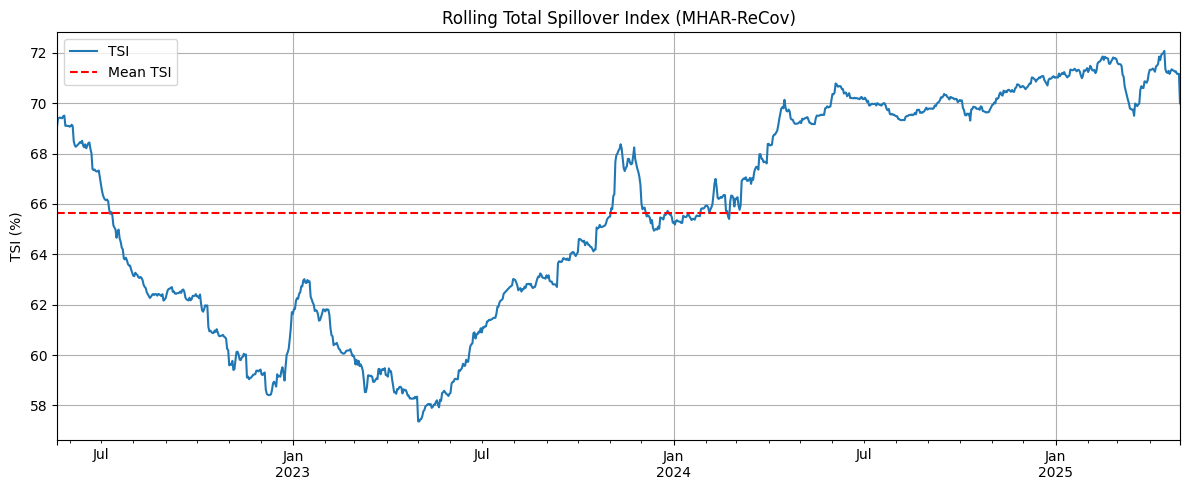

In [14]:
# PLOT TSI

tsi_df.plot(figsize=(12, 5), title='Rolling Total Spillover Index (MHAR-ReCov)', ylabel='TSI (%)')
plt.axhline(tsi_df['TSI'].mean(), color='red', linestyle='--', label='Mean TSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# ────────────────────────────────────────────────────────────
# ❻  stacked plot (variances + covariances)
# ────────────────────────────────────────────────────────────
panel = pd.read_parquet(
    f"parquet_files/rolling_directional_recov_{option_selector.value}.parquet")

if option_selector.value == "europe":
    panel.columns = pd.MultiIndex.from_tuples(
        [(blk, mkt.replace("BZN|", "")) for blk, mkt in panel.columns],
        names=panel.columns.names         
    )

to_var, from_var = panel["TO_VAR"],   panel["FROM_VAR"]
to_cov, from_cov = panel["TO_COV"],   panel["FROM_COV"]
net_tot_df          = panel["NET_TOT"]

markets_raw  = to_var.columns.tolist()     
markets_disp = [m.upper() for m in markets_raw] 

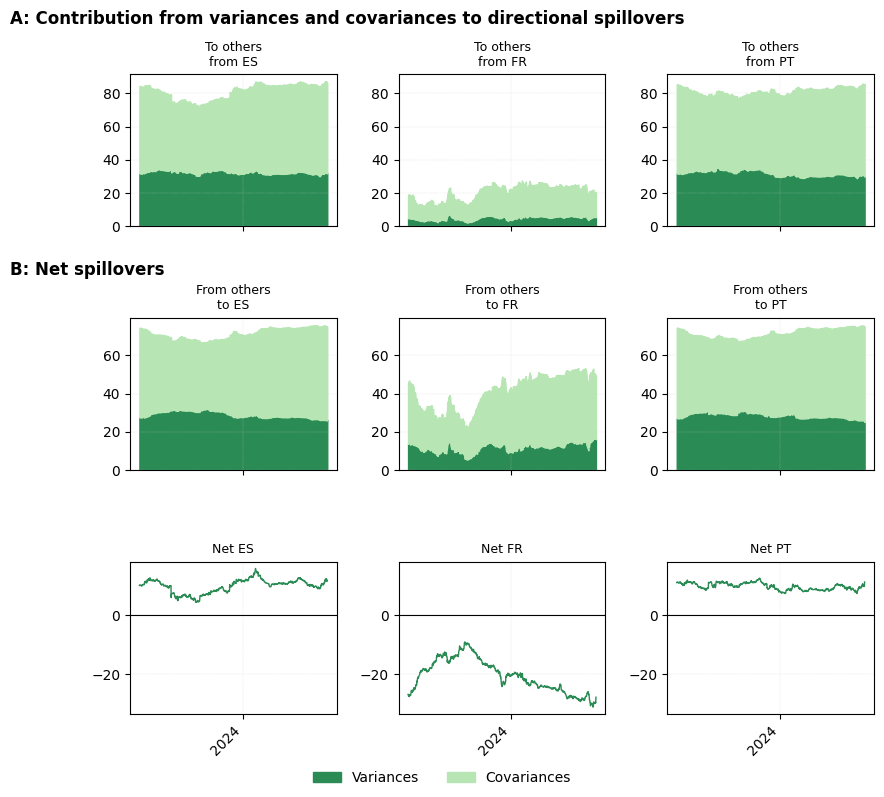

✓ Plot saved to plots/rolling_tsi_both_grid_europe.png


In [18]:

# layout

n_mk      = len(markets)
col_chunk = len(markets)
n_bands   = math.ceil(n_mk / col_chunk)

fig_w, fig_h = 3.2*min(col_chunk, n_mk), 8.0*n_bands
fig, axes = plt.subplots(
    nrows=3*n_bands, ncols=col_chunk,
    figsize=(fig_w, fig_h),
    sharex="row", sharey="row",
    gridspec_kw={"hspace":0.60, "wspace":0.30}) 

col_cov = "#B7E6B4"
col_var = "#2A8B55"
loc, fmt = mdates.YearLocator(base=2), mdates.DateFormatter("%Y")

for i, (raw, disp) in enumerate(zip(markets_raw, markets_disp)):
    band, col = divmod(i, col_chunk)
    rows      = np.arange(3) + band*3

    # ---------- TO others -----------------
    ax = axes[rows[0], col]

    # variance **first**  (dark green, touches the X-axis)
    ax.fill_between(to_var.index,
                    0,                         # lower edge
                    to_var[raw],                 # upper edge
                    color=col_var, zorder=1)

    # covariance **second**  (light green, stacked on top)
    ax.fill_between(to_var.index,
                    to_var[raw],                 # baseline = variance
                    to_var[raw] + to_cov[raw],     # variance + covariance
                    color=col_cov, zorder=2)
    ax.set_title(f"To others\nfrom {raw.upper()}", fontsize=9)
    ax.set_ylim(0, (to_var+to_cov).max().max()*1.05)
    ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
    ax.tick_params(axis="x", labelbottom=False)
    ax.grid(ls=":", lw=.3, color="#d0d0d0")

    # ---------- FROM others ---------------
    ax = axes[rows[1], col]
    ax.fill_between(from_var.index, 0, from_var[raw],                  color=col_var, zorder=1)
    ax.fill_between(from_var.index,
                    from_var[raw],
                    from_var[raw] + from_cov[raw],
                    color=col_cov, zorder=2)
    ax.set_title(f"From others\nto {raw.upper()}", fontsize=9)
    ax.set_ylim(0, (from_var+from_cov).max().max()*1.05)
    ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
    ax.tick_params(axis="x", labelbottom=False)
    ax.grid(ls=":", lw=.3, color="#d0d0d0")

    # ---------- NET (total) ------------
    ax = axes[rows[2], col]
    ax.plot(net_tot_df.index, net_tot_df[raw], color=col_var, lw=1)
    ax.axhline(0, color="black", lw=.8)
    ax.set_title(f"Net {raw.upper()}", fontsize=9)
    ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
    for lab in ax.get_xticklabels():
        lab.set_rotation(45); lab.set_ha("right")
    ax.grid(ls=":", lw=.3, color="#d0d0d0")


for ax in axes.flat:
    ax.tick_params(axis="y", labelleft=True) 

# ── global legend & headings ──────────────────────────────────────────
fig.legend([plt.Rectangle((0,0),1,1,color=col_var),
            plt.Rectangle((0,0),1,1,color=col_cov)],
           ["Variances", "Covariances"],
           ncol=2, loc="lower center", frameon=False)

fig.text(0.00, 0.98,                           # A-header: a hair lower  
         "A: Contribution from variances and covariances to directional spillovers",
         ha="left", va="top", fontsize=12, fontweight="bold")

fig.text(0.00, (3*n_bands-1)/(3*n_bands),      # B-header lower   
         "B: Net spillovers",
         ha="left", va="top", fontsize=12, fontweight="bold")

# final layout – a touch more top / bottom padding                 
plt.subplots_adjust(top=0.90, bottom=0.10)
plt.show()


# save
os.makedirs("plots", exist_ok=True)
out_file = f"plots/rolling_tsi_both_grid_{option_selector.value}.png"
fig.savefig(out_file, dpi=300, transparent=True)
plt.show()
print(f"✓ Plot saved to {out_file}")


In [107]:
# ────────────────────────────────────────────────────────────
# ❼  export: PDF + LaTeX snippet
# ────────────────────────────────────────────────────────────
import pathlib, textwrap

# 1) store the figure ------------------------------------------------
region_tag   = option_selector.value            # "europe" | "australia"
pdf_fname    = f"plots/spillover_recov_panel_{region_tag}.pdf"
fig.savefig(pdf_fname, bbox_inches="tight")
print(f"✓ Panel saved to {pdf_fname}")

# 2) build a LaTeX wrapper ------------------------------------------
latex_dir = pathlib.Path("latex_files"); latex_dir.mkdir(exist_ok=True)
tex_path  = latex_dir / f"fig_spillover_recov_panel_{region_tag}.tex"

caption = r"""
Time-varying spillovers based on MHAR-ReCov.
Panel~A shows the contribution of variances (\textcolor{RGB}{42,139,85}{dark green})
and covariances (\textcolor{RGB}{183,230,180}{light green}) to the directional
spillovers. Panel~B shows the net directional spillovers.
"""

latex_code = textwrap.dedent(fr"""
    \begin{{figure}}[htbp]
      \centering
      \includegraphics[width=\textwidth]{{{pdf_fname}}}
      \caption{{{caption.strip()}}}
      \label{{fig:spillover_recov_panel_{region_tag}}}
    \end{{figure}}
""")

tex_path.write_text(latex_code, encoding="utf-8")
print(f"✓ LaTeX snippet written to {tex_path}")


✓ Panel saved to plots/spillover_recov_panel_europe.pdf
✓ LaTeX snippet written to latex_files\fig_spillover_recov_panel_europe.tex


### Delete this section

In [6]:
# ────────────────────────────────────────────────────────────
# Dynamic spillovers – MHAR-ReCov  (variances + covariances)
# ────────────────────────────────────────────────────────────


window = 365                       # rolling width (days)

# ----- α⋆ once on the full sample ----------------------------
full_XY = create_mhar_lags(pit_vech)
full_X  = full_XY.drop(columns=pit_vech.columns).values
full_Y  = full_XY[pit_vech.columns].values

_, full_model = fit_mhar_lasso(full_X, full_Y)   # → uses LASSO_OPTS
alpha_star    = full_model.alpha_
print(f"α* global = {alpha_star:.3e}")

# -------------------------------------------------------------
# helper for a single rolling window
# -------------------------------------------------------------
def window_metrics(start: int):
    """Return (date, TSI, to-vec, from-vec, net-vec) for one window."""
    end = start + window
    wdf = pit_vech.iloc[start:end]

    mdf = create_mhar_lags(wdf)
    if mdf.empty:                       # first 30 days → no lags yet
        return None

    Xw = mdf.drop(columns=pit_vech.columns).values
    Yw = mdf[pit_vech.columns].values
    K  = Yw.shape[1]

    # 1 ▶ Lasso without CV (α⋆ from full sample)
    model = MultiTaskLasso(alpha=alpha_star,
                           max_iter=50_000, tol=1e-4).fit(Xw, Yw)

    # 2 ▶ residual Σ
    Sigma_w = np.cov((Yw - (Xw @ model.coef_.T + model.intercept_)).T)

    # 3 ▶ Φ₁, FEVD, spillover metrics
    Bd, Bw, Bm = np.split(model.coef_, 3, axis=1)
    phi1       = Bd + Bw/7 + Bm/30
    _, theta_n = gvd([np.eye(K), phi1], Sigma_w)       # θ row-normalised

    tsi_w, to_w, from_w, net_w = spillover_metrics(theta_n)
    return mdf.index[-1], tsi_w, to_w, from_w, net_w

# -------------------------------------------------------------
# rolling loop (parallel)
# -------------------------------------------------------------
starts  = range(len(pit_vech) - window + 1)
n_jobs  = max(cpu_count() - 1, 1)

raw = Parallel(n_jobs=n_jobs)(
        delayed(window_metrics)(s) for s in tqdm(starts))

# drop windows that returned None
valid = [r for r in raw if r is not None]
dates, tsi_vals, to_list, from_list, net_list = zip(*valid)

# -------------------------------------------------------------
# save results (same structure as ReVar)
# -------------------------------------------------------------
idx  = pd.to_datetime(dates)
cols = pit_vech.columns

tsi_df  = pd.DataFrame({"TSI": tsi_vals}, index=idx)
to_df   = pd.DataFrame(to_list  , index=idx, columns=cols)
from_df = pd.DataFrame(from_list, index=idx, columns=cols)
net_df  = pd.DataFrame(net_list , index=idx, columns=cols)

# ① TSI
tsi_df.to_parquet(
    f"parquet_files/rolling_tsi_mhar_recov_{option_selector.value}.parquet"
)

# ② directional panel  (TO | FROM | NET)
pd.concat(
    {"TO": to_df, "FROM": from_df, "NET": net_df},
    axis=1
).to_parquet(
    f"parquet_files/rolling_directional_recov_{option_selector.value}.parquet"
)

print("dynamic ReCov: files written for",
      option_selector.value)


α* global = 1.597e-02


100%|██████████| 3166/3166 [01:03<00:00, 49.90it/s]


✓ dynamic ReCov: files written for australia


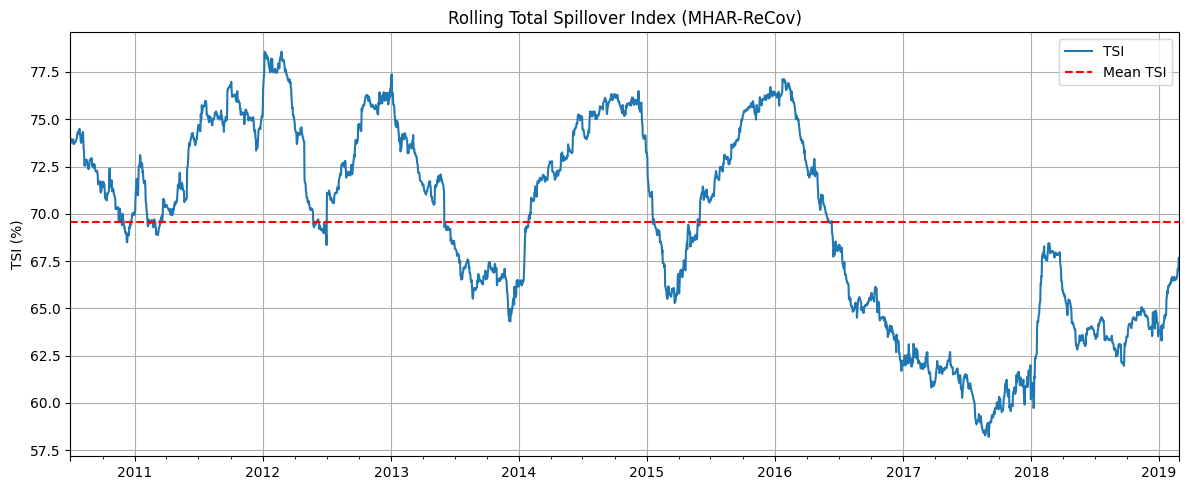

In [19]:
tsi_df.plot(figsize=(12, 5), title='Rolling Total Spillover Index (MHAR-ReCov)', ylabel='TSI (%)')
plt.axhline(tsi_df['TSI'].mean(), color='red', linestyle='--', label='Mean TSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()